# Investigating High School Graduation Rates

1. Initialize & Split up data
2. EDA
4. Simple Linear Regression
5. Feature Selection with Lasso

## Initialize & Split up data

- import libraries
- initialize data
- functions
- split data

In [2038]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

In [2104]:
#Pull in pickled data and initialize dataframe
main_list = []

pickle_files = ['florida_highschool_data', 'alabama_through_illinois_data', 'indiana_through_wyoming']
for file_name in pickle_files:
    picklefile_name = file_name + '.pkl'
    with open(picklefile_name, 'rb') as picklefile: 
        pickle_data = pickle.load(picklefile)
        main_list.extend(pickle_data)

hs_df = pd.DataFrame(main_list)
hs_df.shape

(44658, 190)

According to google, there are only 24K high schools in the US. Given that we have 45K rows, need to filter out any invalid data

In [2105]:
#remove dups
hs_df.sort_values(['school_name','address','grades', 'students'], inplace=True, ascending=False)
hs_df.drop_duplicates(subset=['school_name','address','grades','students'], inplace=True)

#remove schools with 0 students
hs_df = hs_df[hs_df.students != '0']

#remove rows with unspecified demographic for population
hs_df = hs_df[hs_df['Pop Unspecified'] != '100']

#remove schools with ? for number of students
hs_df = hs_df.replace('?', np.NaN).dropna(subset=['students'])

#remove schools without at least an overall graduation rate
hs_df.reset_index()

hs_df.shape

(31874, 190)

Data cleanup code/functions

In [2106]:
hs_df.rename(columns={'Graduation rates;All students': 'grad_rate_all', '4-year high school graduation rate': '4year_grad_rate', 'Graduation rates;Black': 'grad_rate_black', 'Graduation rates;White': 'grad_rate_white', 'Graduation rates;Hispanic': 'grad_rate_hispanic', 'Graduation rates;Asian': 'grad_rate_asian'}, inplace=True)

In [2310]:
def fill_grad_rates(df, grad_rate, population, grad_cols, pop_cols):
    #if the demographic is 100% of population, fill graduation rate of demographic with the grad rate of all students
    df.loc[(df[population] == '100') & (np.isnan(df.grad_rate_all) == False), grad_rate] = df.grad_rate_all

    return df

def fill_pop(df, grad_rate, population):
    '''
    If the demographic population is '<1', fill population rate with:
    - 0 if grad_rate is 0
    - 0.5 if grad_rate is not 0
    '''
    df.loc[(df[population] == '<1') & (df[grad_rate] == '0'), population] = '0'
    df.loc[(df[population] == '<1'), population] = '0.5'
    return df

def drop_na_rows(df):

    '''
    keep all
    '''
    df.dropna(subset=['grad_rate_white', 'grad_rate_hispanic', 'grad_rate_all'], inplace=True)

    drop_rows_list = ['stud_teach_ratio','avg_teach_sal', 'stud_counsel_ratio', 'absent_rate_black', 'absent_rate_white', 'suspension_rate_black', 'suspension_rate_white', 'absent_rate_all']
    
    '''
    filtering
    '''
    # df.dropna(subset=['grad_rate_all'], inplace=True)    
    # drop_rows_list = ['pop_black']

    # filter out NAs for other columns with low # of NaNs
    for row in drop_rows_list:
        df = df.dropna(subset=[row])
        print(f'{row}: {df.shape}')

    return df

def drop_cols(df):
    #find and drop the rest of the columns not targeted
    na_df = df.isna().sum().reset_index()
    drop_columns = list(na_df[na_df[0] != 0].sort_values(by=[0])['index'])

    df = df.drop(columns=drop_columns)

    #Filter out district for now because it has 2454 unique values
    df.drop(columns=['district', 'school_name', 'address', 'rating', '4year_grad_rate'], inplace=True)

    df = df.reset_index()
    return df

def clean_grades_col(df):   
    #filter out these grades that do not have a 12th grade class since we are targetting highschool graduation
    drop_grades = ['6-11', '9-11', '5-10', '9', 'K-11', '12']
    for grade in drop_grades:
        df = df[df.grades != grade]
    
    #if school is not standard 9-12th grade high school, mark as "other"
    df.loc[(df.grades != '9-12'), 'grades'] = 'Other'
    return df

def set_numerical_cols(df):
    #clean up values to usable formats
    df.stud_teach_ratio = df.stud_teach_ratio.map(lambda val: int(val.split(':')[0]))
    df.stud_counsel_ratio = df.stud_counsel_ratio.map(lambda val: int(val.split(':')[0]))
    df.students = df.students.map(lambda val: int(val.replace(',', '')))
    df.avg_teach_sal = df.avg_teach_sal.map(lambda val: int(val.replace('$', '').replace(',','')))

    temp_list = ['grad_rate_white','teach_exp_rate','teach_cert_rate','grad_rate_hispanic', 'grad_rate_black']
    pop_list = ['pop_white','pop_hispanic', 'pop_black']

    '''
    still keeping these in play
    '''
    # temp_list = ['grad_rate_white','grad_rate_black']
    # pop_list = ['pop_black']

    '''
    only keeping pop_black
    '''
    # temp_list = ['grad_rate_black']
    # pop_list = ['pop_black']

    for col in temp_list:
        df = df.astype({col: 'int64'})
    for col in pop_list:
        df = df.astype({col: 'float64'})
    return df

def collapse_states(df):
    '''
    set the lowest volume states to "other"
    '''
    sums = list(df.state.value_counts().sort_values())
    states = reversed(list(df.state.value_counts().index))

    state_count_dict = dict(zip(states, sums))

    for k, v in state_count_dict.items():
        if v < 10:
            df.loc[df.state == k, 'state'] = 'Other'
        else:
            break
    return df

def create_ohe_df(df, cat_list):
    '''
    One hot encoding for categorical variables
    '''
    cat_X = df.loc[:, cat_list]

    # ohe = OneHotEncoder(drop='first', sparse=False)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
    ohe_X = ohe.fit_transform(cat_X)
    columns = ohe.get_feature_names(cat_list)

    cat_df = pd.DataFrame(ohe_X, columns=columns, index=cat_X.index)

    df = pd.concat([df, cat_df], axis=1)

    df.drop(columns=cat_list, inplace=True)
    print(df.shape)
    return df

def clean_data(func_df, i):
    func_df.rename(columns={'AP course participation': 'ap_course_rate','Percentage of students enrolled in Dual Enrollment classes grades 9-12': 'dual_enroll_rate','Percentage of students enrolled in IB grades 9-12': 'ib_enroll_rate', '% suspended;All students': 'suspension_rate_all', '% suspended;Black': 'suspension_rate_black','% suspended;White': 'suspension_rate_white', 'Pop Black': 'pop_black', 'Pop White': 'pop_white', 'Pop Hispanic': 'pop_hispanic','Students per teacher': 'stud_teach_ratio', 'Students per counselor': 'stud_counsel_ratio','Average teacher salary': 'avg_teach_sal','Percentage of teachers with 3 or more years experience': 'teach_exp_rate','% of full time teachers who are certified': 'teach_cert_rate','% chronically absent;All students': 'absent_rate_all', '% chronically absent;White': 'absent_rate_white', '% chronically absent;Black': 'absent_rate_black', 'Pop Asian': 'pop_asian'}, inplace=True)

    #if grad_rate_all is NaN, but there is a value for '4year graduation rate, fill in grad_rate_all. they are the same
    func_df.loc[np.isnan(func_df.grad_rate_all) & (np.isnan(func_df['4year_grad_rate']) == False), 'grad_rate_all'] = func_df['4year_grad_rate']

    #for each ethnicity: if the population of that ethincity is 100%, that means all other ethnicities have population of 0%. They also have 0% graduates of other ethnicities because they do not exist at that school
    grad_cols = ['grad_rate_black', 'grad_rate_white', 'grad_rate_hispanic', 'grad_rate_asian']
    pop_cols = ['pop_black', 'pop_white', 'pop_hispanic', 'pop_asian']

    for idx, val in enumerate(grad_cols):
        func_df = fill_grad_rates(func_df, val, pop_cols[idx], grad_cols, pop_cols)

    #keep only rows with value for black grad rate
    grad_black_df = func_df[func_df['grad_rate_black'].notna()]

    #clear out '<1' in population columns for each ethnicity
    for idx, val in enumerate(grad_cols):
        grad_black_df = fill_pop(grad_black_df, val, pop_cols[idx])

    #drop rows with NAs in desired columns
    grad_black_df = drop_na_rows(grad_black_df)

    #drop columns we don't need
    grad_black_df = drop_cols(grad_black_df)

    #clean up 'grades' category and condense
    grad_black_df = clean_grades_col(grad_black_df)

    #set cols to numbers
    grad_black_df = set_numerical_cols(grad_black_df)

    #collapse states with low volume < 10 to 'Other
    #grad_black_df = collapse_states(grad_black_df)

    #get ohe df
    # cat_list = ['state','grades','school_type']
    cat_list = ['grades','school_type']
    grad_black_df = create_ohe_df(grad_black_df, cat_list)

    # mask = (grad_black_df['pop_black'] >= 4)
    mask = (grad_black_df['pop_black'] >= i)

    grad_black_df = grad_black_df[mask]

    return grad_black_df

Split out train/val/test data

In [2295]:
#pull out 20% of data for test
x, y = hs_df.drop('grad_rate_black', axis=1), hs_df['grad_rate_black']

x_, x_test, y_, y_test = train_test_split(x, y, test_size=.2, random_state=10)

#and another 20% for validate
x_train, x_val, y_train, y_val = train_test_split(x_, y_, test_size=.2, random_state=3)

## 2. EDA

In [2122]:
#build/clean train_df
x_train['grad_rate_black'] = list(y_train)
full_train = clean_data(x_train)

stud_teach_ratio: (4162, 190)
avg_teach_sal: (4132, 190)
stud_counsel_ratio: (3944, 190)
absent_rate_black: (3768, 190)
absent_rate_white: (3756, 190)
suspension_rate_black: (3602, 190)
suspension_rate_white: (3601, 190)
absent_rate_all: (3601, 190)
(3594, 25)


Feature correlations

<AxesSubplot:>

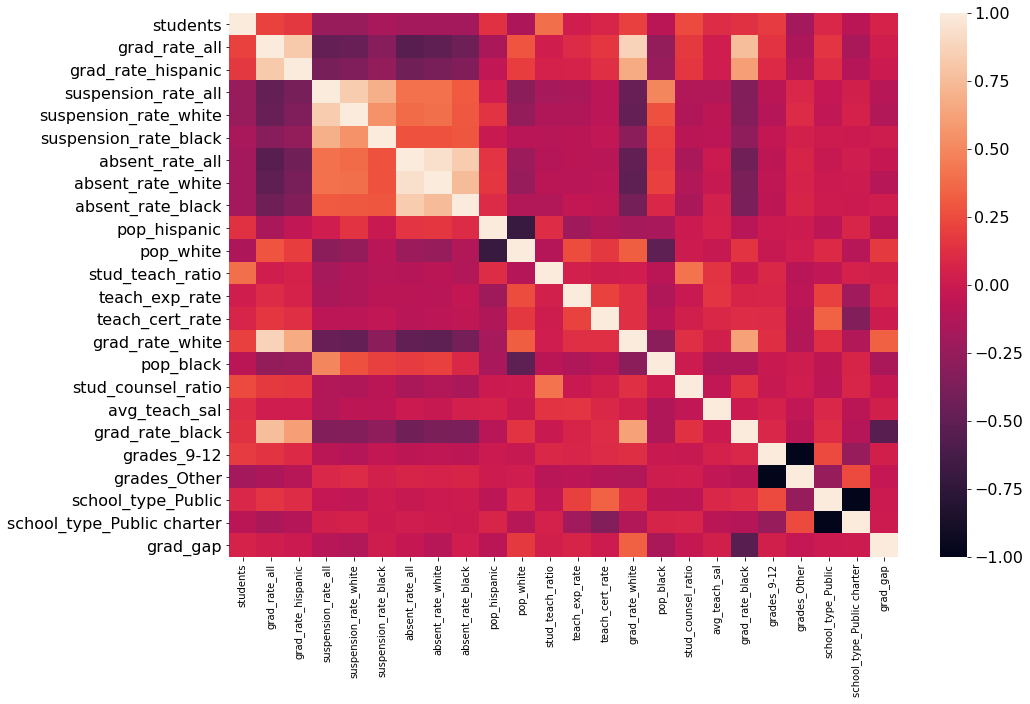

In [2078]:
plt.figure(figsize = (15,10))
sns.heatmap(full_train.drop(columns='index').corr())

Split up columns into 3 sections to view pairplots separately for all 24 features

In [2123]:
x_vals = full_train.drop(columns=['grad_rate_black', 'index'])
y_vals = full_train['grad_rate_black']

sec1_pair = x_vals.iloc[:, :9]
sec1_pair['grad_rate_black'] = y_vals

sec2_pair = x_vals.iloc[:, 9:18]
sec2_pair['grad_rate_black'] = y_vals

sec3_pair = x_vals.iloc[:, 18:]
sec3_pair['grad_rate_black'] = y_vals

In [2343]:
#sns.pairplot(sec1_pair)

In [2344]:
#sns.pairplot(sec2_pair)

In [2345]:
#sns.pairplot(sec3_pair)

In [2124]:
# add grad gap for analysis
full_train['grad_gap'] = full_train['grad_rate_white'] - full_train['grad_rate_black']

(-20.0, 20.0, 0.0, 650.0)

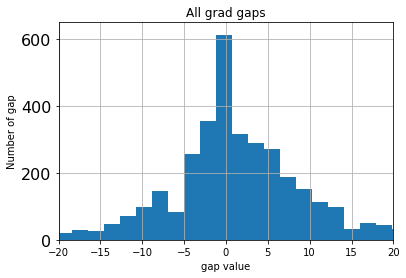

In [2071]:
full_train['grad_gap'].hist(bins=100)
sns.mpl.pyplot.title("All grad gaps")
sns.mpl.pyplot.ylabel("Number of gap")
sns.mpl.pyplot.xlabel("gap value")
plt.axis([-20, 20, 0, 650])

(65.0, 100.0, 0.0, 1000.0)

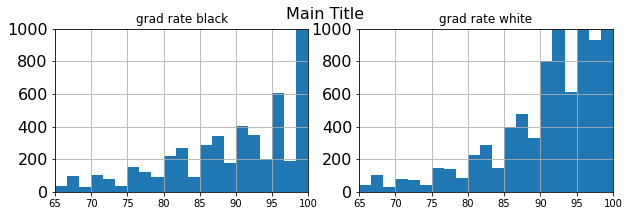

In [2062]:
plt.figure(figsize=[10,3])

plt.suptitle('Main Title',fontsize = 16)

plt.subplot(1,2,1) # (number of rows, number of columns, number of plot)
x_train['grad_rate_black'].hist(bins=60)
plt.title('grad rate black')
plt.axis([65, 100, 0, 1000])

plt.subplot(1,2,2)
x_train['grad_rate_white'].hist(bins=60)
plt.title('grad rate white');
plt.axis([65, 100, 0, 1000])

## 3. Simple Linear Regression

In [2271]:
def train_rate(train_, grad_rate):
    '''
    Train linear regression model
    Input: dataframe, target variable
    Output: model fit, scaler fit, model score, mse
    '''
    func_df = train_.copy()

    #predict black grad rate
    x_train_df = func_df.drop(columns=[grad_rate])
    y_train_df = func_df[grad_rate]
    print(x_train_df.shape)

    #standardize
    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_df.values)

    ln = LinearRegression()
    ln.fit(x_train_scaled,y_train_df)

    score = ln.score(x_train_scaled,y_train_df)

    y_pred = ln.predict(x_train_scaled)
    mse = mean_squared_error(y_train_df, y_pred)

    print(f'train {grad_rate}: {score}')
    print(f'train mse: {mse}')
    print(f'train sqrt mse: {np.sqrt(mse)}')

    scores_dict_[f'train {grad_rate}'] = score

    return ln, scaler, score, mse

def pred_rate(ln, scaler_gen, func_df, grad_rate, check_str):
    '''
    Test model
    Input: model fit, scaler fit, dataframe, target variable, indicator for val or test
    Output: dataframe with residuals added and score
    Also saves score to dictionary and prints score, mse, rmse
    '''
    x_val_df = func_df.drop(columns=[grad_rate])
    # x_val_df = func_df.drop(columns=['index', grad_rate])
    y_val_df = func_df[grad_rate]
    print(x_val_df.shape)

    #standardize
    x_val_scaled = scaler_gen.transform(x_val_df.values)

    score = ln.score(x_val_scaled,y_val_df)

    y_pred = ln.predict(x_val_scaled)
    mse = mean_squared_error(y_val_df, y_pred)

    residuals = y_val_df - y_pred
    func_df['res'] = residuals

    print(f'{check_str} {grad_rate}: {score}')
    print(f'{check_str} mse: {mse}')
    print(f'{check_str} sqrt mse: {np.sqrt(mse)}')

    scores_dict_[f'{check_str} {grad_rate}'] = score
    return func_df, score

def init_data_split(x_func, y_func):
    scores_dict_ = {}

    #build/clean train_df
    x_func['grad_rate_black'] = list(y_func)
    x_func = clean_data(x_func)

    x_func.drop(columns=['state', 'index'], inplace=True)
    return x_func

def train_check(full_train, full_check, target, check_str):
    train_ = full_train.copy()
    check_ = full_check.copy()
    
    ln, scaler, score, mse = train_rate(train_, target)

    cols = ['Nurse', 'Psychologist', 'Social worker', 'ib_enroll_rate', 'dual_enroll_rate', 'ap_course_rate']
    for col in cols:
        try:
            check_.drop(columns=col, inplace=True)
        except:
            pass

    #validate black rate
    full_val_res, score = pred_rate(ln, scaler, check_, target, check_str)
    return

### Linear Regression - Black student graduation rate

In [2272]:
#set target for model
target = 'grad_rate_black'

Train / Validate

In [2274]:
full_train = init_data_split(x_train, y_train)
full_val = init_data_split(x_val, y_val)

train_check(full_train, full_val, target, 'val')

stud_teach_ratio: (4162, 190)
avg_teach_sal: (4132, 190)
stud_counsel_ratio: (3944, 190)
absent_rate_black: (3768, 190)
absent_rate_white: (3756, 190)
suspension_rate_black: (3602, 190)
suspension_rate_white: (3601, 190)
absent_rate_all: (3601, 190)
(3594, 25)
stud_teach_ratio: (1013, 190)
avg_teach_sal: (1003, 190)
stud_counsel_ratio: (945, 190)
absent_rate_black: (902, 190)
absent_rate_white: (900, 190)
suspension_rate_black: (853, 190)
suspension_rate_white: (853, 190)
absent_rate_all: (850, 190)
(849, 30)
(3594, 22)
train grad_rate_black: 0.6016900298047168
train mse: 93.83713798828867
train sqrt mse: 9.68695710676416
(849, 22)
val grad_rate_black: 0.718275129034216
val mse: 72.24194399163302
val sqrt mse: 8.499526103944444


Train / Test

In [2276]:
#put train/val together
train_val = full_train.append(full_val)
train_val.drop(columns=['Nurse', 'Psychologist', 'Social worker', 'ib_enroll_rate', 'dual_enroll_rate'], inplace=True)

full_test = init_data_split(x_test, y_test)

train_check(train_val, full_test, target, 'test')

stud_teach_ratio: (1242, 190)
avg_teach_sal: (1232, 190)
stud_counsel_ratio: (1170, 190)
absent_rate_black: (1114, 190)
absent_rate_white: (1111, 190)
suspension_rate_black: (1069, 190)
suspension_rate_white: (1069, 190)
absent_rate_all: (1069, 190)
(1066, 31)
(4443, 22)
train grad_rate_black: 0.6272194663889794
train mse: 89.30781641970164
train sqrt mse: 9.45028128786131
(1066, 22)
test grad_rate_black: 0.6181138777295176
test mse: 89.49390522800897
test sqrt mse: 9.460121840019237


### Linear Regression - White student graduation rate

In [2254]:
#set target for model
target = 'grad_rate_white'

Train / Validate

In [2255]:
full_train = init_data_split(x_train, y_train)
full_val = init_data_split(x_val, y_val)

train_check(full_train, full_val, target, 'val')

stud_teach_ratio: (6303, 190)
avg_teach_sal: (6249, 190)
stud_counsel_ratio: (5841, 190)
absent_rate_black: (5351, 190)
absent_rate_white: (5335, 190)
suspension_rate_black: (5055, 190)
suspension_rate_white: (5054, 190)
absent_rate_all: (5054, 190)
(5043, 23)
stud_teach_ratio: (1554, 190)
avg_teach_sal: (1536, 190)
stud_counsel_ratio: (1422, 190)
absent_rate_black: (1303, 190)
absent_rate_white: (1300, 190)
suspension_rate_black: (1218, 190)
suspension_rate_white: (1218, 190)
absent_rate_all: (1215, 190)
(1213, 27)
(5043, 20)
train grad_rate_white: 0.8122879236837963
train mse: 33.51361101421489
train sqrt mse: 5.789094144528563
(1213, 20)
val grad_rate_white: 0.8126317357141732
val mse: 36.04880981669414
val sqrt mse: 6.004066106955697


Train / Test

In [2256]:
#put train/val together
train_test = full_train.append(full_test)
train_test.drop(columns=['Nurse', 'Psychologist', 'Social worker', 'ib_enroll_rate'], inplace=True)

full_test = init_data_split(x_test, y_test)

train_check(train_test, full_test, target, 'test')

stud_teach_ratio: (1902, 190)
avg_teach_sal: (1886, 190)
stud_counsel_ratio: (1726, 190)
absent_rate_black: (1577, 190)
absent_rate_white: (1573, 190)
suspension_rate_black: (1494, 190)
suspension_rate_white: (1494, 190)
absent_rate_all: (1493, 190)
(1490, 27)
(6533, 20)
train grad_rate_white: 0.8043681247373156
train mse: 35.41114903176691
train sqrt mse: 5.950726765006683
(1490, 20)
test grad_rate_white: 0.7832600962445566
test mse: 41.043047987633294
test sqrt mse: 6.406484838632906


### Linear Regression - Grad gap (white - black)

In [2296]:
target = 'grad_gap'

In [2297]:
#predict grad gap (white - black)
full_train = init_data_split(x_train, y_train)
full_train['grad_gap'] = full_train['grad_rate_white'] - full_train['grad_rate_black']
full_train_gap = full_train.drop(columns=['grad_rate_black', 'grad_rate_white'])

full_val = init_data_split(x_val, y_val)
full_val['grad_gap'] = full_val['grad_rate_white'] - full_val['grad_rate_black']
full_val_gap = full_val.drop(columns=['grad_rate_black', 'grad_rate_white'])

train_check(full_train_gap, full_val_gap, target, 'val')

stud_teach_ratio: (4162, 190)
avg_teach_sal: (4132, 190)
stud_counsel_ratio: (3944, 190)
absent_rate_black: (3768, 190)
absent_rate_white: (3756, 190)
suspension_rate_black: (3602, 190)
suspension_rate_white: (3601, 190)
absent_rate_all: (3601, 190)
(3594, 25)
stud_teach_ratio: (1013, 190)
avg_teach_sal: (1003, 190)
stud_counsel_ratio: (945, 190)
absent_rate_black: (902, 190)
absent_rate_white: (900, 190)
suspension_rate_black: (853, 190)
suspension_rate_white: (853, 190)
absent_rate_all: (850, 190)
(849, 30)
(3594, 21)
train grad_gap: 0.09949147355487964
train mse: 146.55992707800453
train sqrt mse: 12.106193748573684
(849, 21)
val grad_gap: 0.05269890006500211
val mse: 131.99563766925667
val sqrt mse: 11.488935445429949


In [2298]:
#put train/val together
train_test_gap = full_train_gap.append(full_test_gap)
train_test_gap.drop(columns=['ap_course_rate', 'dual_enroll_rate', 'ib_enroll_rate', 'Nurse', 'Psychologist', 'Social worker'], inplace=True)

full_test = init_data_split(x_test, y_test)
full_test['grad_gap'] = full_test['grad_rate_white'] - full_test['grad_rate_black']
full_test_gap = full_test.drop(columns=['grad_rate_black', 'grad_rate_white'])

train_check(train_test_gap, full_test_gap, target, 'test')

stud_teach_ratio: (1242, 190)
avg_teach_sal: (1232, 190)
stud_counsel_ratio: (1170, 190)
absent_rate_black: (1114, 190)
absent_rate_white: (1111, 190)
suspension_rate_black: (1069, 190)
suspension_rate_white: (1069, 190)
absent_rate_all: (1069, 190)
(1066, 31)
(4660, 21)
train grad_gap: 0.10103146757739068
train mse: 148.07897209064515
train sqrt mse: 12.168770360666896
(1066, 21)
test grad_gap: 0.12129539252089072
test mse: 150.56628456552755
test sqrt mse: 12.2705454061964


## 4. Feature selection with Lasso

In [2307]:
cols = ['Nurse', 'Psychologist', 'Social worker', 'ib_enroll_rate', 'dual_enroll_rate', 'ap_course_rate', 'grad_gap']
for col in cols:
    try:
        full_test.drop(columns=col, inplace=True)
    except:
        pass

In [2339]:
flag = 'full'
if flag == 'full':
    train = full_train
    val = full_val
    test = full_test
else:
    train = filter_train
    val = filter_val
    test = filter_test

x_train_df = train.drop(columns=['grad_rate_black'])
y_train_df = train['grad_rate_black']
print(x_train_df.shape)

x_val_df = val.drop(columns=['grad_rate_black'])
y_val_df = val['grad_rate_black']

# x_test_df = test.drop(columns=['grad_rate_black'])
# y_test_df = test['grad_rate_black']

#standardize
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_df.values)
x_val_scaled = scaler.transform(x_val_df.values)
x_test_scaled = scaler.transform(x_test_df.values)

# alphavec = 10**np.linspace(-100,100,2000)
# lassocv = LassoCV(alphas = alphavec, cv=5, random_state=0)
lassocv = LassoCV(cv=5, random_state=0)
lassocv.fit(x_train_scaled, y_train_df)

print('train')
print(lassocv.score(x_train_scaled, y_train_df))
score = lassocv.score(x_val_scaled, y_val_df)
print('val', score)

y_pred = lassocv.predict(x_val_scaled)
mse = mean_squared_error(y_val_df, y_pred)
print('mse', mse)

score = lassocv.score(x_test_scaled, y_test_df)
print('test', score)
y_pred = lassocv.predict(x_test_scaled)
mse = mean_squared_error(y_test_df, y_pred)
print('mse', mse)

lassocv.alpha_

(3594, 22)
train
0.6015925581034292
val 0.719711111316254
mse 71.87371895265672
test 0.6227926070680031
mse 88.39745857654003


0.015405802946048677

In [1182]:
coef_df = pd.DataFrame(list(zip(x_val_df.columns,lassocv.coef_)))

coef_df[1] = abs(coef_df[1])

In [1183]:
coef_df.sort_values(by=1, ascending=False)

,0,1
3,grad_rate_all,1.480623e+01
16,grad_rate_white,2.175374e+00
4,grad_rate_hispanic,1.271562e+00
7,suspension_rate_black,1.168275e+00
9,absent_rate_white,1.141322e+00
8,absent_rate_all,9.214496e-01
10,absent_rate_black,8.443182e-01
17,pop_black,7.382274e-01
5,suspension_rate_all,7.214896e-01
11,pop_hispanic,6.401003e-01


### Pare down based on lasso results

In [2292]:
scores_dict_ = {}

#build/clean train_df
full_train = clean_data(x_train)

#validate df
full_val = clean_data(x_val)

#test df
full_test = clean_data(x_test)

stud_teach_ratio: (4162, 190)
avg_teach_sal: (4132, 190)
stud_counsel_ratio: (3944, 190)
absent_rate_black: (3768, 190)
absent_rate_white: (3756, 190)
suspension_rate_black: (3602, 190)
suspension_rate_white: (3601, 190)
absent_rate_all: (3601, 190)
(3594, 25)
stud_teach_ratio: (1013, 190)
avg_teach_sal: (1003, 190)
stud_counsel_ratio: (945, 190)
absent_rate_black: (902, 190)
absent_rate_white: (900, 190)
suspension_rate_black: (853, 190)
suspension_rate_white: (853, 190)
absent_rate_all: (850, 190)
(849, 30)
stud_teach_ratio: (1242, 190)
avg_teach_sal: (1232, 190)
stud_counsel_ratio: (1170, 190)
absent_rate_black: (1114, 190)
absent_rate_white: (1111, 190)
suspension_rate_black: (1069, 190)
suspension_rate_white: (1069, 190)
absent_rate_all: (1069, 190)
(1066, 31)


In [2309]:
#Black pop ONLY
filter_train = full_train.loc[:,['grad_rate_black', 'grad_rate_all']]

#train black grad rate
ln_black, scaler_black, score_black, mse_black = train_rate(filter_train, 'grad_rate_black')

(3594, 1)
train grad_rate_black: 0.5764887793788661
train mse: 99.77425578759593
train sqrt mse: 9.98870641212344


### Expand to broader volume by removing NA constraints on non-needed features

Additional filter set in clean_data. Found model predicts well for schools with black student population >= 8%, but does not predict well for schools with population under 8%.

In [2034]:
scores_dict_ = {}
j = 0

#build/clean train_df
full_train = clean_data(x_train, j)

#validate df
full_val = clean_data(x_val, j)

#test df
full_test = clean_data(x_test, j)

(5757, 11)
(1419, 11)
(1763, 11)


Train / validate on data only with 'grad_rate_all'

Target: grad_rate_black

In [2036]:
#bigger sample size
filter_train = full_train.loc[:,['grad_rate_black', 'grad_rate_all', 'pop_black']]

#train black grad rate
ln_black, scaler_black, score_black, mse_black = train_rate(filter_train, 'grad_rate_black')

(3969, 2)
train grad_rate_black: 0.909169846921389
train mse: 47.030988102015996
train sqrt mse: 6.8579142676192735


In [2031]:
filter_val = full_val.loc[:,['grad_rate_black', 'grad_rate_all', 'pop_black']]

#validate black rate
filter_val, score = pred_rate(ln_black, scaler_black, filter_val, 'grad_rate_black', 'val')

(442, 2)
val grad_rate_black: 0.6173745007234601
val mse: 212.4845757671619
val sqrt mse: 14.576850680691008


Test on data with black student population < 8% to understand how bad model is on that subset

In [2037]:
# filter_test = full_test.loc[:,['grad_rate_black', 'grad_rate_all', 'pop_black']]
filter_test = filter_test.drop(columns='res')

#test black rate
filter_test, score = pred_rate(ln_black, scaler_black, filter_test, 'grad_rate_black', 'test')

temp_dict = {}
temp_dict['proportion'] = full_test.shape[0]
temp_dict['score'] = round(score, 2)

(574, 2)
test grad_rate_black: 0.4711769316692521
test mse: 262.3118364875053
test sqrt mse: 16.196043852975492


grad_rate_all vs grad_rate_black for schools with < 8% population

<AxesSubplot:xlabel='grad_rate_all', ylabel='grad_rate_black'>

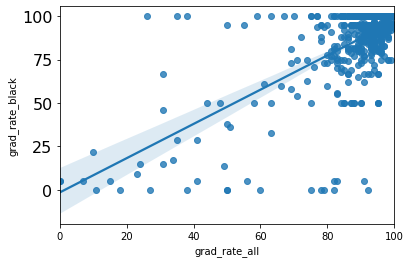

In [2315]:
# use the function regplot to make a scatterplot
sns.regplot(x=filter_test["grad_rate_all"], y=filter_test["grad_rate_black"])

Plot residuals of general model to black student population. It looks like the higher variance is around schools with low black population rates

Text(0, 0.5, 'Residuals')

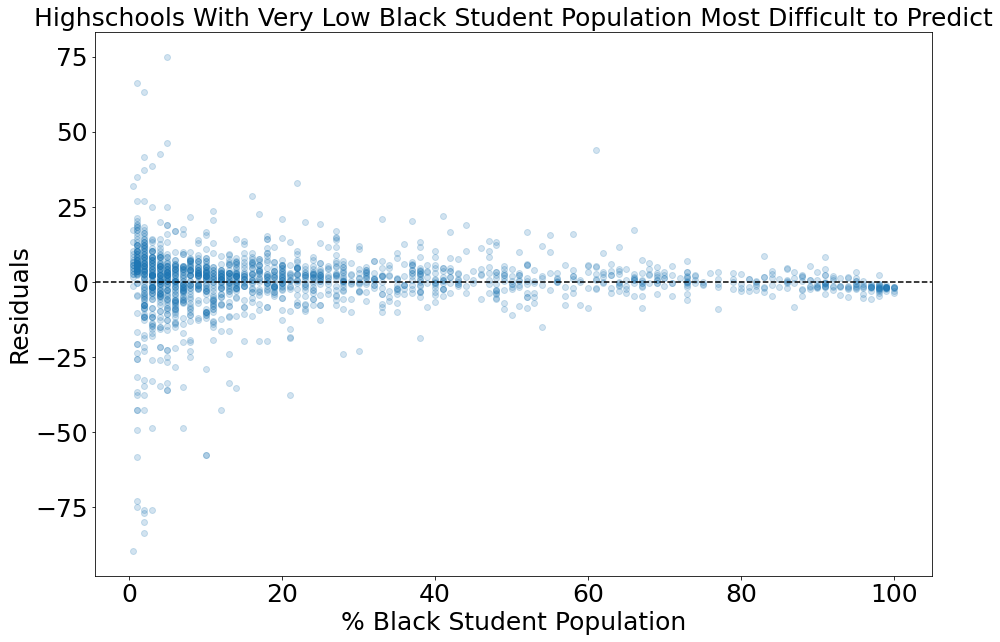

In [1627]:
plt.figure(figsize = (15,10))
plt.scatter(filter_test["pop_black"], filter_test["res"], alpha = 0.2)
plt.axhline(0, linestyle = '--', color='black')
plt.title('Highschools With Very Low Black Student Population Most Difficult to Predict', fontsize=25)
plt.xlabel('% Black Student Population')
plt.ylabel('Residuals')

Ran through train/test/val for multiple filters of black student population from >=1% through >=10%

In [1738]:
pop_scores_df = pd.DataFrame(pop_scores_list)

In [1739]:
pop_scores_df['perc_total'] = round((pop_scores_df['proportion'] / pop_scores_df['total']), 3) * 100
pop_scores_df['score'] = round(pop_scores_df['score'], 2)
# pop_scores_df['min_perc'] = str(pop_scores_df['pop_black_min']) + '%'
pop_scores_df['score_perc'] = pop_scores_df['score'] * 100
pop_scores_df['perc_diff'] = 100 - pop_scores_df['perc_total']
pop_scores_df

,proportion,score,total,pop_black_min,perc_total,score_perc,perc_diff
0,1742,0.78,1763,1,98.8,78.0,1.2
1,1647,0.81,1763,2,93.4,81.0,6.6
2,1545,0.86,1763,3,87.6,86.0,12.4
3,1458,0.87,1763,4,82.7,87.0,17.3
4,1381,0.88,1763,5,78.3,88.0,21.7
5,1305,0.90,1763,6,74.0,90.0,26.0
6,1242,0.90,1763,7,70.4,90.0,29.6
7,1189,0.91,1763,8,67.4,91.0,32.6
8,1139,0.91,1763,9,64.6,91.0,35.4
9,1096,0.91,1763,10,62.2,91.0,37.8


Run through train/val/test for multiple filters of white student population from >= 1% through >=10%

In [1900]:
temp_dict['total'] = 3164
temp_dict['pop_white_min'] = j

In [1901]:
temp_dict
pop_scores_list.append(temp_dict)
pop_scores_list

[{'proportion': 3154, 'score': 0.87, 'total': 3164, 'pop_white_min': 1},
 {'proportion': 3120, 'score': 0.89, 'total': 3164, 'pop_white_min': 2},
 {'proportion': 3103, 'score': 0.9, 'total': 3164, 'pop_white_min': 3},
 {'proportion': 3081, 'score': 0.9, 'total': 3164, 'pop_white_min': 4},
 {'proportion': 3059, 'score': 0.91, 'total': 3164, 'pop_white_min': 5},
 {'proportion': 3037, 'score': 0.92, 'total': 3164, 'pop_white_min': 6},
 {'proportion': 3004, 'score': 0.92, 'total': 3164, 'pop_white_min': 7},
 {'proportion': 2989, 'score': 0.92, 'total': 3164, 'pop_white_min': 8},
 {'proportion': 2970, 'score': 0.92, 'total': 3164, 'pop_white_min': 9},
 {'proportion': 2946, 'score': 0.92, 'total': 3164, 'pop_white_min': 10}]

In [1902]:
pop_white_df = pd.DataFrame(pop_scores_list)

In [1903]:
pop_white_df['perc_total'] = round((pop_white_df['proportion'] / pop_white_df['total']), 3) * 100
pop_white_df['score'] = round(pop_white_df['score'], 2)
pop_white_df['score_perc'] = pop_white_df['score'] * 100
pop_white_df['perc_diff'] = 100 - pop_white_df['perc_total']
pop_white_df

,proportion,score,total,pop_white_min,perc_total,score_perc,perc_diff
0,3154,0.87,3164,1,99.7,87.0,0.3
1,3120,0.89,3164,2,98.6,89.0,1.4
2,3103,0.90,3164,3,98.1,90.0,1.9
3,3081,0.90,3164,4,97.4,90.0,2.6
4,3059,0.91,3164,5,96.7,91.0,3.3
5,3037,0.92,3164,6,96.0,92.0,4.0
6,3004,0.92,3164,7,94.9,92.0,5.1
7,2989,0.92,3164,8,94.5,92.0,5.5
8,2970,0.92,3164,9,93.9,92.0,6.1
9,2946,0.92,3164,10,93.1,92.0,6.9


Plot R^2 value to different filtered models for both black and white sets

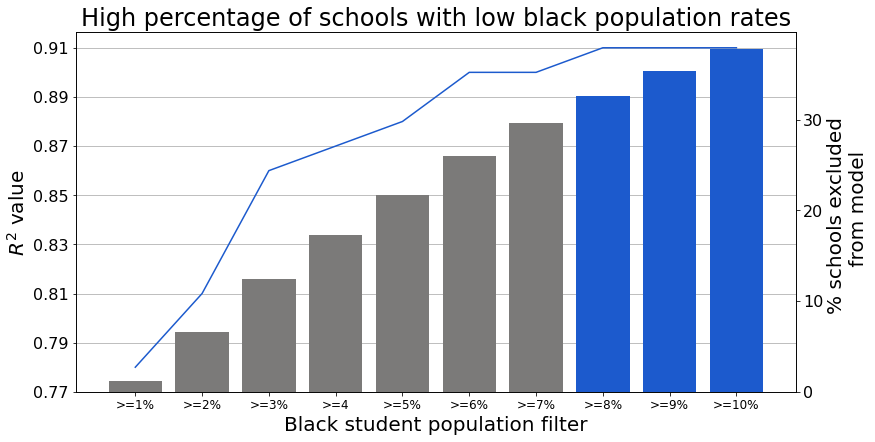

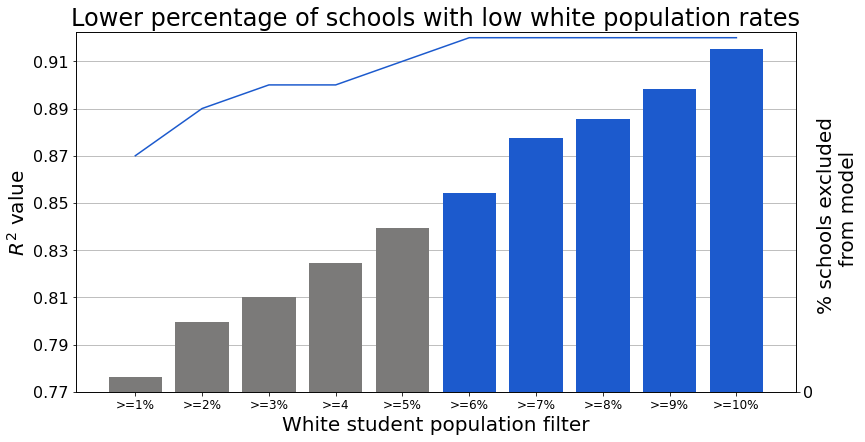

In [2314]:
plots = [(pop_scores_df, 0), (pop_white_df, 1)]

for plot_, bar_color_flag in plots:

    fig = plt.figure(figsize=(10, 5))
    length = len(pop_scores_df)
    ax1 = fig.add_axes([0, 0, 1, 1])
    ax2 = fig.add_axes()

    # This is the magic that joins the x-axis
    ax2 = ax1.twinx()

    ax1.plot(plot_['score'], '#1C5ACD')

    ax2.set_ylabel('% schools excluded \n from model', fontsize=20)
    ax2.set_yticks(np.arange(0, 110, step=10))

    #blue = #1C5ACD
    #gray = 7B7A79

    ax1.set_ylabel('$R^2$ value', fontsize=20)
    ax1.set_yticks(np.arange(0.77, 0.91, step=0.02))

    # ax1.set_xlabel('Black student population filter', fontsize=20)
    ax1.set_xticks(np.arange(0, 10, step=1))
    ax1.set_xticklabels(['>=1%', '>=2%', '>=3%', '>=4', '>=5%', '>=6%', '>=7%', '>=8%', '>=9%', '>=10%'], fontsize=12)

    # plt.title('High percentage of schools with low black population rates', fontsize=24)
    plt.rc('ytick', labelsize=16)          # controls default text sizes

    #variable with chart
    if bar_color_flag == 0:
        ax2.bar(range(0,length),plot_['perc_diff'], color=['#7B7A79', '#7B7A79', '#7B7A79', '#7B7A79', '#7B7A79', '#7B7A79', '#7B7A79', '#1C5ACD', '#1C5ACD', '#1C5ACD'])
        ax1.set_xlabel('Black student population filter', fontsize=20)
        plt.title('High percentage of schools with low black population rates', fontsize=24)

    else:
        ax2.bar(range(0,length),plot_['perc_diff'], color=['#7B7A79', '#7B7A79', '#7B7A79', '#7B7A79', '#7B7A79', '#1C5ACD', '#1C5ACD', '#1C5ACD', '#1C5ACD', '#1C5ACD'])
        ax1.set_xlabel('White student population filter', fontsize=20)
        plt.title('Lower percentage of schools with low white population rates', fontsize=24)

    ax1.yaxis.grid()

### Set and plot national average graduation rates for 2014 - 2018

In [2323]:
#high school national graduation rates for 2014 - 2018
overall = [82, 83, 84, 85, 85]
white = [87, 88, 88, 89, 89]
black = [73, 75, 76, 78, 79]
hispanic = [76, 78, 79, 80, 81]

nat_grad = []
nat_grad = [overall, white, black, hispanic]
nat_grad

[[82, 83, 84, 85, 85],
 [87, 88, 88, 89, 89],
 [73, 75, 76, 78, 79],
 [76, 78, 79, 80, 81]]

In [2324]:
#create dataframe for plotting
nat_df = pd.DataFrame(nat_grad)
nat_df = nat_df.transpose()
nat_df.rename(columns={0: 'overall', 1: 'white', 2: 'black', 3: 'hispanic'}, inplace=True)
nat_df['X'] = [0, 1, 2, 3, 4]
nat_df

,overall,white,black,hispanic,X
0,82,87,73,76,0
1,83,88,75,78,1
2,84,88,76,79,2
3,85,89,78,80,3
4,85,89,79,81,4


<Figure size 1440x720 with 0 Axes>

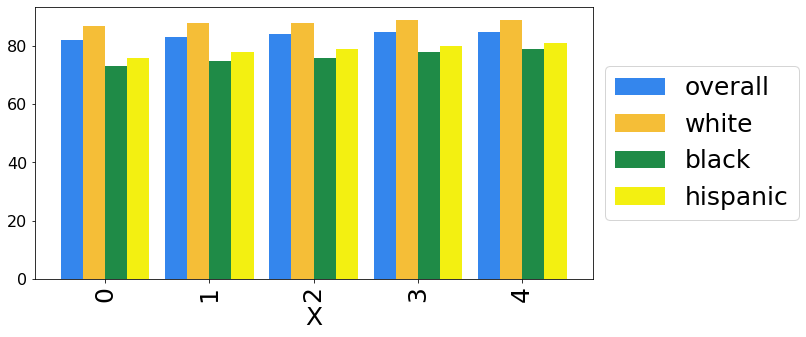

In [1993]:
plt.figure(figsize = (20,10))

# my_colors = ['#5561D4', '#D49755', '#33BB35', '#D2D53D']
my_colors = ['#3486ED', '#F5BE37', '#1F8B47', '#F3F011']
nat_df.plot(x="X", y=["overall", "white", "black", "hispanic"], kind="bar", color=my_colors, width=0.85, figsize=(10,5))
# nat_df.plot(figsize=(10,10));
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()